In [61]:
import torch, torchvision.transforms as T
from torchvision import models
from PIL import Image
import os, glob, pandas as pd, numpy as np, scipy.stats as stats, matplotlib.pyplot as plt, seaborn as sns
from torchvision.models import alexnet, AlexNet_Weights
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from matplotlib import colormaps
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import ast
from scipy.stats import spearmanr


## get alexnet embeddings of stims used in expt

In [62]:
df_subj = pd.read_csv(glob.glob('../results/*tori*')[0])
df_subj = df_subj.dropna(subset=['positions'])
print(len(df_subj))

# sort by trial key
df_subj = df_subj.sort_values(by='trial_key').reset_index(drop=True)

# convert str to list
for col in ['positions']:
    if type(df_subj[col][0]) == str:
        df_subj[col] = df_subj[col].apply(lambda x: ast.literal_eval(x))

# store chosen position
df_subj['chosen_pos'] = df_subj['positions'].apply(lambda x: x[-1])
# store if flipped
df_subj['flipped'] = np.where( df_subj['shape_order'] == 'curv_flat', 0, 1) 
# rename conditions if subj session in [B,D]
if df_subj['sess_type'][0] in ['B', 'D']:
    df_subj['condition'] = df_subj['condition'].map({'baseline': 'baseline', 'pen_comp': 'rew_comp', 'rew_comp': 'pen_comp'})
# store unflipped div_pos
df_subj['div_true'] = df_subj['condition'].map({'baseline': 0, 'pen_comp': -.2, 'rew_comp': .2})
# store correct class
df_subj['class_true'] = np.where( df_subj['shape'] == 'flat', 1, 0 )
# store chosen class
df_subj['class_pred'] = np.where( df_subj['stim_pos'] > df_subj['div_true'], 1, 0 )

df_subj[['target_file', 'blockN', 'condition', 'div_true', 'flipped', 'div_pos', 'stim_pos', 'target_pos', 'chosen_pos', 'class_true', 'class_pred', 'noise_pos']].iloc[55:65]


240


,target_file,blockN,condition,div_true,flipped,div_pos,stim_pos,target_pos,chosen_pos,class_true,class_pred,noise_pos
55,input_data/stims/Shape_0.70_0.00.png,2.0,pen_comp,-0.2,1,0.2,-0.26,0.26,0.258,0,0,0.0
56,input_data/stims/Shape_0.90_0.00.png,2.0,pen_comp,-0.2,0,-0.2,-0.22,-0.22,-0.165,0,0,0.0
57,input_data/stims/Shape_0.90_0.00.png,2.0,pen_comp,-0.2,1,0.2,-0.22,0.22,0.222,0,0,0.0
58,input_data/stims/Shape_0.90_0.00.png,2.0,pen_comp,-0.2,0,-0.2,-0.22,-0.22,-0.257,0,0,0.0
59,input_data/stims/Shape_0.90_0.00.png,2.0,pen_comp,-0.2,1,0.2,-0.22,0.22,0.304,0,0,0.0
60,input_data/stims/Shape_1.10_4.00.png,2.0,pen_comp,-0.2,0,-0.2,-0.18,-0.18,-0.129,1,1,4.0
61,input_data/stims/Shape_1.10_4.00.png,2.0,pen_comp,-0.2,1,0.2,-0.18,0.18,-0.102,1,1,4.0
62,input_data/stims/Shape_1.30_4.00.png,2.0,pen_comp,-0.2,0,-0.2,-0.14,-0.14,-0.270,1,1,4.0
63,input_data/stims/Shape_1.30_4.00.png,2.0,pen_comp,-0.2,1,0.2,-0.14,0.14,0.228,1,1,4.0
64,input_data/stims/Shape_1.50_4.00.png,2.0,pen_comp,-0.2,0,-0.2,-0.10,-0.10,-0.170,1,1,4.0


In [63]:
# # load pretrainded AlexNet model
# model = models.alexnet(weights=AlexNet_Weights.DEFAULT).eval()
# # remove the last layer to get the feature vector
# model.classifier = torch.nn.Sequential(*list(model.classifier.children())[:-1])
# # transform the input image to the format expected by the model
# transform = T.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor(), T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# def get_embeddings(img_path):
#     img = transform(Image.open(img_path).convert('RGB')).unsqueeze(0)
#     with torch.no_grad():
#     # with torch.no_grad() is used to disable gradient calculation
#         return model(img)



# # get list of shapes used as targets
# trials_df = pd.read_csv('../input_data/trials_no_noise.csv')
# shape_files_used = trials_df['target_file'].tolist()
# alex_embeds = [(shape_file, get_embeddings(os.path.join('../', shape_file))) for shape_file in shape_files_used]

# # convert to df
# alexnet_df = pd.DataFrame([(k, *v.squeeze().numpy()) for k, v in alex_embeds])
# alexnet_df.columns = ['shapes'] + [f'feature_{i}' for i in range(alexnet_df.shape[1] - 1)]

# # append associated stim & noise positions
# alexnet_df['stim_file_pos'] = trials_df['stim_file_pos']
# alexnet_df['noise_pos'] = trials_df['noise_pos']
# alexnet_df['div'] = trials_df['condition'].map({'baseline': 2, 'curv_comp': 1, 'flat_comp': 3})

# # append block number
# alexnet_df['block'] = np.repeat(np.arange(len(alexnet_df) // 40) + 1, 40)

# # additional cols based on combinations of conditions
# conditions = [
#     (alexnet_df['stim_file_pos'] < alexnet_df['div']) & (alexnet_df['div'] == 1),
#     (alexnet_df['stim_file_pos'] > alexnet_df['div']) & (alexnet_df['div'] == 1),
#     (alexnet_df['stim_file_pos'] < alexnet_df['div']) & (alexnet_df['div'] == 2),
#     (alexnet_df['stim_file_pos'] > alexnet_df['div']) & (alexnet_df['div'] == 2),
#     (alexnet_df['stim_file_pos'] < alexnet_df['div']) & (alexnet_df['div'] == 3),
#     (alexnet_df['stim_file_pos'] > alexnet_df['div']) & (alexnet_df['div'] == 3),
# ]
# values = [1, 2, 3, 4, 5, 6]
# alexnet_df['ShapeDiv_combo'] = np.select(conditions, values, default=np.nan)

# reorder_columns = ['shapes', 'block', 'div', 'stim_file_pos', 'noise_pos', 'ShapeDiv_combo'] + [col for col in alexnet_df.columns if col.startswith('feature_')]
# alexnet_df = alexnet_df[reorder_columns]

# # remove features with minimal variance across shapes
# feature_cols = [col for col in alexnet_df.columns if col.startswith('feature_')]
# variances = alexnet_df[feature_cols].var()
# threshold = 0.2
# low_variance_features = variances[variances < threshold].index
# alexnet_df = alexnet_df.drop(columns=low_variance_features)

# alexnet_df.to_csv('../input_data/alex_embeds.csv', index=False)

In [173]:
# load pretrainded AlexNet model
model = models.alexnet(weights=AlexNet_Weights.DEFAULT).eval()
# remove the last layer to get the feature vector
model.classifier = torch.nn.Sequential(*list(model.classifier.children())[:-1])
# transform the input image to the format expected by the model
transform = T.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor(), T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

def get_embeddings(img_path):
    img = transform(Image.open(img_path).convert('RGB')).unsqueeze(0)
    with torch.no_grad():
    # with torch.no_grad() is used to disable gradient calculation
        return model(img)
    
    
# 1. Load trial metadata
trials_df = pd.read_csv('../input_data/trials_no_noise.csv')
shape_files_used = trials_df['target_file'].tolist()

# 2. Extract AlexNet embeddings
alex_embeds = [(shape_file, get_embeddings(os.path.join('../', shape_file))) for shape_file in shape_files_used]
embedding_matrix = np.stack([v.squeeze().numpy() for _, v in alex_embeds])
shape_names = [k for k, _ in alex_embeds]

# 3. Apply PCA to embeddings
pca = PCA(n_components=.99,)
pca_features = pca.fit_transform(embedding_matrix)

# 4. Form DataFrame: shape name + PCA features
pca_cols = [f'feature_{i}' for i in range(pca_features.shape[1])]
alexnet_df = pd.DataFrame(pca_features, columns=pca_cols)
alexnet_df.insert(0, 'shapes', shape_names)

# 5. Append more metadata
alexnet_df[['blockN', 'condition', 'stim_pos', 'target_pos', 'noise_pos', 'div_pos']] = trials_df[['blockN', 'condition', 'stim_pos', 'target_pos', 'noise_pos', 'div_pos']]
alexnet_df['flipped'] = np.where( trials_df['shape_order'] == 'curv_flat', 0, 1) 
alexnet_df['condition'] = trials_df['condition'].map({'baseline': 'baseline', 'curv_comp': 'pen_comp', 'flat_comp': 'rew_comp'})
alexnet_df['div_true'] = alexnet_df['condition'].map({'baseline': 0, 'pen_comp': -.2, 'rew_comp': .2})
alexnet_df['class_true'] = np.where( trials_df['shape'] == 'flat', 1, 0 )

# 7. Reorder and save
reorder_columns = ['shapes', 'blockN', 'condition', 'div_true', 'flipped', 'div_pos', 'stim_pos', 'target_pos', 'class_true', 'noise_pos'] + pca_cols
alexnet_df = alexnet_df[reorder_columns]

alexnet_df.to_csv('../input_data/alex_embeds.csv', index=False)


In [183]:
alexnet_df = pd.read_csv('../input_data/alex_embeds.csv')
print(alexnet_df.shape)
alexnet_df.iloc[75:85]

(240, 23)


,shapes,blockN,condition,div_true,flipped,div_pos,stim_pos,target_pos,class_true,noise_pos,...,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12
75,input_data/stims/Shape_2.50_2.00.png,2,pen_comp,-0.2,1,0.2,0.10,-0.10,1,2.0,...,1.683349,0.972265,-0.293418,0.796073,0.895192,-0.224963,-1.085299,-1.498274,0.371446,-0.771840
76,input_data/stims/Shape_2.70_2.00.png,2,pen_comp,-0.2,0,-0.2,0.14,0.14,1,2.0,...,4.803146,0.566892,-2.506440,0.673169,-1.487677,1.165249,-0.809972,-0.387176,-1.242142,0.594532
77,input_data/stims/Shape_2.70_2.00.png,2,pen_comp,-0.2,1,0.2,0.14,-0.14,1,2.0,...,4.803146,0.566892,-2.506440,0.673169,-1.487677,1.165249,-0.809972,-0.387176,-1.242142,0.594532
78,input_data/stims/Shape_2.90_2.00.png,2,pen_comp,-0.2,0,-0.2,0.18,0.18,1,2.0,...,5.117041,-0.857703,-1.920685,-0.511779,1.233452,-0.998833,0.063326,-0.462613,0.253392,-0.499357
79,input_data/stims/Shape_2.90_2.00.png,2,pen_comp,-0.2,1,0.2,0.18,-0.18,1,2.0,...,5.117041,-0.857703,-1.920685,-0.511779,1.233452,-0.998833,0.063326,-0.462613,0.253392,-0.499357
80,input_data/stims/Shape_1.10_2.00.png,3,rew_comp,0.2,0,0.2,-0.18,-0.18,0,2.0,...,-2.356548,-1.549429,0.297975,0.918921,2.698014,-0.121347,-1.899060,0.707211,0.418050,1.022135
81,input_data/stims/Shape_1.10_2.00.png,3,rew_comp,0.2,1,-0.2,-0.18,0.18,0,2.0,...,-2.356548,-1.549429,0.297975,0.918921,2.698014,-0.121347,-1.899060,0.707211,0.418050,1.022135
82,input_data/stims/Shape_1.30_2.00.png,3,rew_comp,0.2,0,0.2,-0.14,-0.14,0,2.0,...,-0.661704,-4.079053,-0.519676,1.007450,-1.261591,0.678368,0.848516,-0.428710,1.841415,-0.692042
83,input_data/stims/Shape_1.30_2.00.png,3,rew_comp,0.2,1,-0.2,-0.14,0.14,0,2.0,...,-0.661704,-4.079053,-0.519676,1.007450,-1.261591,0.678368,0.848516,-0.428710,1.841415,-0.692042
84,input_data/stims/Shape_1.50_2.00.png,3,rew_comp,0.2,0,0.2,-0.10,-0.10,0,2.0,...,-2.695011,-2.134236,-0.966339,1.380805,-2.073398,-1.006280,1.292642,0.358253,-1.731841,0.203043


## plot stim embeddings from alexnet

alex_embeds_df.shape (n_trials, n_feats): (240, 13)


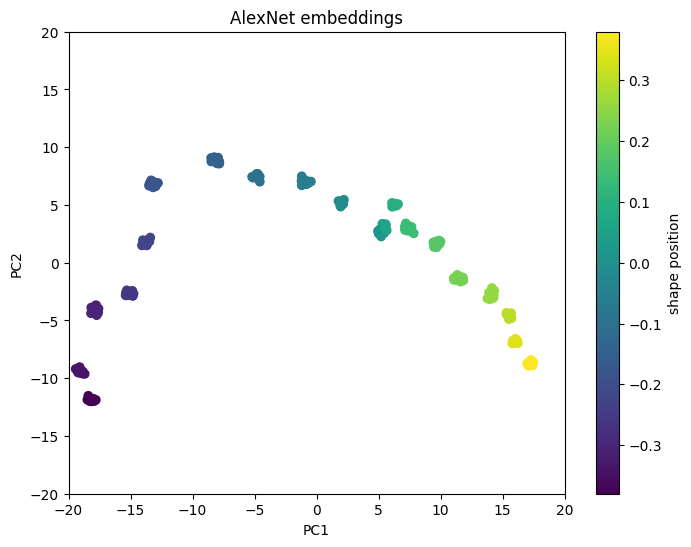

In [184]:
# sub-select cols
alex_embeds_df = alexnet_df[alexnet_df.columns[alexnet_df.columns.str.startswith('feature_')]]
print(f'alex_embeds_df.shape (n_trials, n_feats): {alex_embeds_df.shape}')

pca = PCA(n_components=2)
alex_feat_pc_df = pd.DataFrame(pca.fit_transform(alex_embeds_df),
                               columns=['PC1', 'PC2'])

plt.figure(figsize=(8, 6))
jitter = .2
scatter = plt.scatter(alex_feat_pc_df['PC1'] + np.random.normal(0, jitter, size=len(alex_feat_pc_df)),
                      alex_feat_pc_df['PC2'] + np.random.normal(0, jitter, size=len(alex_feat_pc_df)),
                      c = alexnet_df['stim_pos'].values)

plt.colorbar(scatter, label='shape position')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xlim(-20,20)
plt.ylim(-20,20)
plt.title('AlexNet embeddings')
plt.show()


## building architecture of new NN

In [185]:
import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim

class ShapeSideNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, recon_dim, class_dim):
        super(ShapeSideNN, self).__init__()
        
        # single intermediate layer
        self.hidden = nn.Linear(input_dim, hidden_dim)
        
        # separate outputs
        self.reconstruction_output = nn.Linear(hidden_dim, recon_dim)
        self.classification_output = nn.Linear(hidden_dim, class_dim)

    def forward(self, x):
        x = F.relu(self.hidden(x))
        
        # output for reconstruction (continuous)
        reconstruction = self.reconstruction_output(x)
        
        # sigmoid output for classification (binary)
        # classification = torch.sigmoid(self.classification_output(x))
        classification = self.classification_output(x)
        
        return reconstruction, classification

## format features (X) & predictions (y_reg & y_class)

In [186]:
# 1.
feature_cols = [col for col in alexnet_df.columns if col.startswith('feature_')]
# features = alex embeds + div_pos + flipped
X = np.column_stack((alexnet_df[feature_cols].values,
                     alexnet_df['div_pos'].values,alexnet_df['flipped'].values))

# 2.
y_class = alexnet_df['class_true'].values.reshape(-1, 1) # shape class (0 or 1)

# 3.
y_reg = alexnet_df['target_pos'].values.reshape(-1, 1) # regression target
# y_reg = df_subj['chosen_pos'].values.reshape(-1, 1)

print(f'X.shape (n_trials, n_feats + div_cntxt): {X.shape}')

def weight_per_sample(labels, preds, tp, tn, fp, fn):
    weights = torch.ones_like(preds)  # init to all 1s
    weights[(labels == 1) & (preds == 1)] = tp  # true positive
    weights[(labels == 0) & (preds == 0)] = tn  # true negative
    weights[(labels == 0) & (preds == 1)] = fp  # false positive
    weights[(labels == 1) & (preds == 0)] = fn  # false negative
    return weights

X.shape (n_trials, n_feats + div_cntxt): (240, 15)


## cross-validation

random state: 990

# false pos: 2
# false neg: 4
class accuracy: 0.917

regression spearman r: 0.993, p: 0.000
regression pearson r: 0.996, p: 0.000


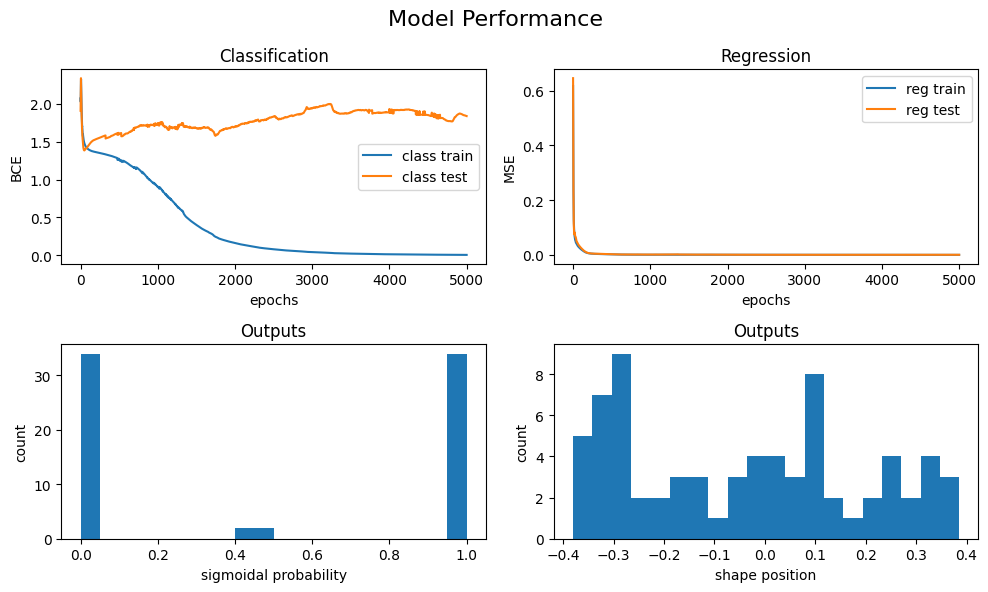

In [221]:
# architecture params
input_dim, hidden_dim, reg_dim, class_dim = X.shape[1], 64, y_reg.shape[1], 1
model = ShapeSideNN(input_dim, hidden_dim, reg_dim, class_dim)

# loss params
optimizer = optim.Adam(model.parameters(), lr=0.001)
reg_wt, class_wt = .5, .5
scale_fact = 2
tp, tn, fp, fn = 6, 4, 0, 2
# tp, tn, fp, fn = 1, 1, 1, 1

rand_state = np.random.randint(0, 1000)
rand_state = 990
print(f'random state: {rand_state}')
# split into train and test once
X_train, X_test, y_reg_train, y_reg_test, y_class_train, y_class_test = train_test_split(
    X, y_reg, y_class, test_size=.3, stratify=y_class, shuffle=True, random_state=rand_state
)

# convert ys to tensors to be able to compare against preds
y_reg_train, y_class_train = torch.tensor(y_reg_train, dtype=torch.float32), torch.tensor(y_class_train, dtype=torch.float32)
y_reg_test, y_class_test = torch.tensor(y_reg_test, dtype=torch.float32), torch.tensor(y_class_test, dtype=torch.float32)

train_total_losses, train_reg_losses, train_class_losses = [], [], []
test_total_losses, test_reg_losses, test_class_losses = [], [], []
epochs = 5000

# training loop
for epoch in range(epochs):
    model.train()

    # forward pass to predict regstruction & class
    pred_reg_train, pred_class_train = model(torch.tensor(X_train, dtype=torch.float32))

    # 1. regstruction loss between pred & y
    train_reg_loss = nn.MSELoss()(pred_reg_train, y_reg_train)

    # 2. class loss
    train_class_loss = nn.BCEWithLogitsLoss()(pred_class_train, y_class_train)

    # 2. classification loss
    # a. first get BCE per sample
    # no reduction means it unpacks, doesnt just avg out samples
    bce = nn.BCEWithLogitsLoss(reduction='none')(pred_class_train, y_class_train)
    
    # b. next, get binary classes
    pred_class_train_binarized = (torch.sigmoid(pred_class_train) >= .5).float()

    # c. get weight per sample depending on (true, pred)
    wts = weight_per_sample(y_class_train.squeeze(), pred_class_train_binarized.squeeze(), tp, tn, fp, fn)

    # d. weighted error
    train_class_loss = (wts * bce).mean()

    # 3. weighted summed training loss
    train_total_loss = (reg_wt * train_reg_loss) + (class_wt * train_class_loss)

    # backward pass and optimization
    optimizer.zero_grad()
    train_total_loss.backward()
    # to try to take care of exploding gradients (manifested as sudden, high losses)?
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()

    # testing model
    model.eval()
    with torch.no_grad():

        # predict test shape & class using trained model
        pred_reg_test, pred_class_test = model(torch.tensor(X_test, dtype=torch.float32))        

        # 1. reg losses between pred & y
        test_reg_loss = nn.MSELoss()(pred_reg_test, y_reg_test)

        # 2. class loss
        test_class_loss = nn.BCEWithLogitsLoss()(pred_class_test, y_class_test)

        # 2. class loss
        # a. first get BCE per sample
        # no reduction means it unpacks, doesnt just avg out samples
        bce = nn.BCEWithLogitsLoss(reduction='none')(pred_class_test, y_class_test)
        
        # b. next, get binary classes
        pred_class_test_binarized = (torch.sigmoid(pred_class_test) >= .5).float()

        # c. get weight per sample depending on (true, pred)
        wts = weight_per_sample(y_class_test.squeeze(), pred_class_test_binarized.squeeze(), tp, tn, fp, fn)

        # d. weighted error
        test_class_loss = (wts * bce).mean()
    
        # 3. weighted summed testing loss
        test_total_loss = (reg_wt * test_reg_loss) + (class_wt * test_class_loss)

    # appending train & test losses
    train_reg_losses.append(train_reg_loss.item())
    train_class_losses.append(train_class_loss.item())
    train_total_losses.append(train_total_loss.item())

    test_reg_losses.append(test_reg_loss.item())
    test_class_losses.append(test_class_loss.item())
    test_total_losses.append(test_total_loss.item())

    # stop early when class accuracy > .8 for last 5 epochs


    # loss_thresh = 0.2
    # if test_total_loss.item() <= loss_thresh:
    #     print(f'loss < {loss_thresh}, stopped at epoch {epoch}')
    #     break


fig, axs = plt.subplots(2, 2, figsize=(10, 6))
axs, ax = axs.flatten(), 0
fig.suptitle('Model Performance', fontsize=16)

# 1. class loss
axs[ax].plot(train_class_losses, label='class train')
axs[ax].plot(test_class_losses, label='class test')
axs[ax].set_xlabel('epochs')
axs[ax].set_ylabel('BCE')
# axs[0].set_ylim(0, 5)
axs[ax].set_title('Classification')
axs[ax].legend()
ax += 1

# 2. reg loss
axs[ax].plot(train_reg_losses, label='reg train')
axs[ax].plot(test_reg_losses, label='reg test')
axs[ax].set_xlabel('epochs')
axs[ax].set_ylabel('MSE')
# axs[0].set_ylim(0, 5)
axs[ax].set_title('Regression')
axs[ax].legend()
ax += 1

# 3. classification: sigmoidal probabilities
sigmoid_probs = torch.sigmoid(pred_class_test).detach().numpy()

false_pos = np.sum((sigmoid_probs > .5) & (y_class_test.numpy() == 0))
print()
print(f'# false pos: {false_pos}')
false_neg = np.sum((sigmoid_probs < .5) & (y_class_test.numpy() == 1))
print(f'# false neg: {false_neg}')
print(f'class accuracy: {(len(sigmoid_probs) - false_pos - false_neg) / len(sigmoid_probs):.3f}')

axs[ax].hist(sigmoid_probs, bins=20)
axs[ax].set_xlabel('sigmoidal probability')
axs[ax].set_ylabel('count')
axs[ax].set_title('Outputs')
ax += 1

# 4. regression to shape position
true_pos, pred_pos = y_reg_test.squeeze(), pred_reg_test.detach().numpy().squeeze()
r, p = stats.spearmanr(pred_pos, true_pos)
print()
print(f'regression spearman r: {r:.3f}, p: {p:.3f}')
r, p = stats.pearsonr(pred_pos, true_pos)
print(f'regression pearson r: {r:.3f}, p: {p:.3f}')

reg_outputs = pred_reg_test.numpy().squeeze()
axs[ax].hist(reg_outputs, bins=20)
axs[ax].set_xlabel('shape position')
axs[ax].set_ylabel('count')
axs[ax].set_title('Outputs')

plt.tight_layout()
plt.show()


## visualize hidden layer

In [222]:
# Get hidden layer activations
with torch.no_grad():
    nn_hidden = model.hidden(torch.tensor(X, dtype=torch.float32)).numpy()

# create column names and convert to df
hidden_cols = [f'hidden_{i}' for i in range(nn_hidden.shape[1])]
hidden_df = pd.DataFrame(nn_hidden, columns=hidden_cols)
print(f'nn_hidden_df.shape (n_trials, n_hidden_units): {hidden_df.shape}')


nn_hidden_df.shape (n_trials, n_hidden_units): (240, 64)


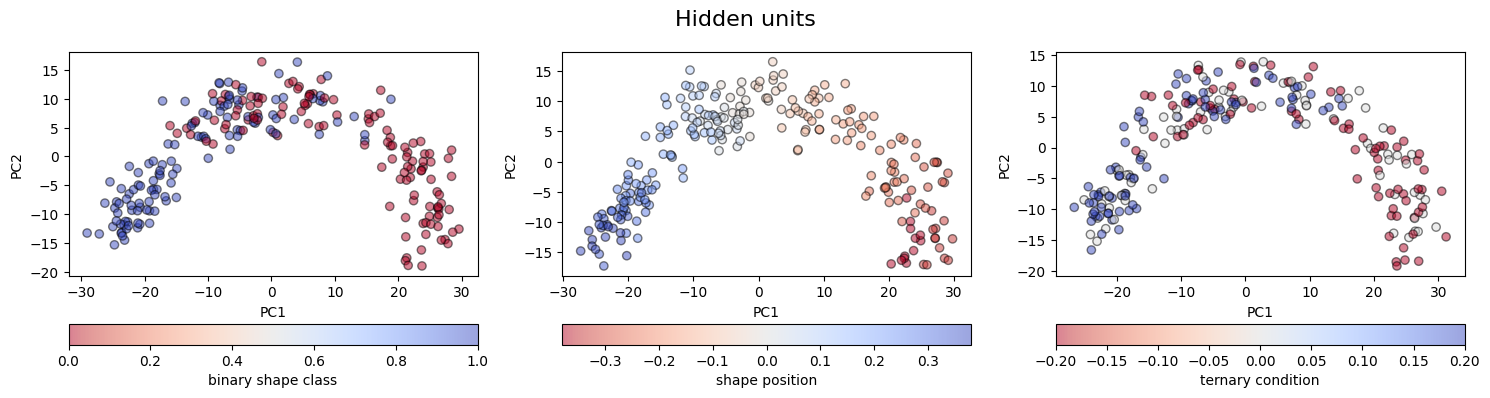

In [223]:
pca = PCA(n_components=2)
hidden_pc_df = pd.DataFrame(pca.fit_transform(hidden_df), columns=['PC1', 'PC2'])

fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs, ax = axs.flatten(), 0
fig.suptitle('Hidden units', fontsize=16)
jitter = 2

# a.
scatter1 = axs[ax].scatter(hidden_pc_df['PC1'] + np.random.normal(0, jitter, size=len(hidden_pc_df)),
                          hidden_pc_df['PC2'] + np.random.normal(0, jitter, size=len(hidden_pc_df)),
                          c = alexnet_df['class_true'], cmap='coolwarm_r', edgecolor='k', alpha=0.5, marker='o')
fig.colorbar(scatter1, ax=axs[ax], orientation='horizontal', label='binary shape class')
axs[ax].set_xlabel('PC1')
axs[ax].set_ylabel('PC2')
ax += 1

# b.
scatter2 = axs[ax].scatter(hidden_pc_df['PC1'] + np.random.normal(0, jitter, size=len(hidden_pc_df)),
                          hidden_pc_df['PC2'] + np.random.normal(0, jitter, size=len(hidden_pc_df)),
                          c = alexnet_df['stim_pos'], cmap='coolwarm_r', edgecolor='k', alpha=0.5, marker='o')
fig.colorbar(scatter2, ax=axs[ax], orientation='horizontal', label='shape position')
axs[ax].set_xlabel('PC1')
axs[ax].set_ylabel('PC2')
ax += 1

# c.
scatter2 = axs[ax].scatter(hidden_pc_df['PC1'] + np.random.normal(0, jitter, size=len(hidden_pc_df)),
                          hidden_pc_df['PC2'] + np.random.normal(0, jitter, size=len(hidden_pc_df)),
                          c = alexnet_df['div_true'], cmap='coolwarm_r', edgecolor='k', alpha=0.5, marker='o')
fig.colorbar(scatter2, ax=axs[ax], orientation='horizontal', label='ternary condition')
axs[ax].set_xlabel('PC1')
axs[ax].set_ylabel('PC2')
ax += 1

plt.tight_layout()
plt.show()


## distance from neutral

In [224]:
nn_df = pd.concat([alexnet_df.drop(columns=[col for col in alexnet_df.columns if col.startswith('features_')]),
                   hidden_df], axis=1)
nn_df.iloc[75:85]


,shapes,blockN,condition,div_true,flipped,div_pos,stim_pos,target_pos,class_true,noise_pos,...,hidden_54,hidden_55,hidden_56,hidden_57,hidden_58,hidden_59,hidden_60,hidden_61,hidden_62,hidden_63
75,input_data/stims/Shape_2.50_2.00.png,2,pen_comp,-0.2,1,0.2,0.10,-0.10,1,2.0,...,0.498932,-2.343487,-2.066175,0.459751,-2.081469,1.882702,2.764798,-3.703243,1.575639,-4.005231
76,input_data/stims/Shape_2.70_2.00.png,2,pen_comp,-0.2,0,-0.2,0.14,0.14,1,2.0,...,0.520241,-2.109970,-1.674613,-1.325420,-0.158235,1.255094,-1.188611,-4.482362,-1.552731,1.290580
77,input_data/stims/Shape_2.70_2.00.png,2,pen_comp,-0.2,1,0.2,0.14,-0.14,1,2.0,...,0.348930,-2.878158,-1.192817,-1.730452,-2.189709,0.839080,1.190077,-5.374100,1.552857,-1.281086
78,input_data/stims/Shape_2.90_2.00.png,2,pen_comp,-0.2,0,-0.2,0.18,0.18,1,2.0,...,2.490153,-1.858969,-0.939143,-2.741266,-1.890788,1.940806,0.268782,-4.628743,-1.552009,0.584570
79,input_data/stims/Shape_2.90_2.00.png,2,pen_comp,-0.2,1,0.2,0.18,-0.18,1,2.0,...,2.318841,-2.627158,-0.457347,-3.146298,-3.922262,1.524791,2.647471,-5.520481,1.553579,-1.987095
80,input_data/stims/Shape_1.10_2.00.png,3,rew_comp,0.2,0,0.2,-0.18,-0.18,0,2.0,...,-4.923957,4.065524,-2.137168,3.782560,1.456429,-3.170733,-0.156173,2.132977,3.420448,0.237437
81,input_data/stims/Shape_1.10_2.00.png,3,rew_comp,0.2,1,-0.2,-0.18,0.18,0,2.0,...,-5.380141,3.225516,-0.796022,6.261395,1.022652,-2.749192,-0.155202,1.855777,3.422943,0.225314
82,input_data/stims/Shape_1.30_2.00.png,3,rew_comp,0.2,0,0.2,-0.14,-0.14,0,2.0,...,-2.532269,3.804924,-2.588063,2.172256,-0.822815,-3.322531,1.465133,-0.391607,0.032533,2.084504
83,input_data/stims/Shape_1.30_2.00.png,3,rew_comp,0.2,1,-0.2,-0.14,0.14,0,2.0,...,-2.988454,2.964916,-1.246917,4.651091,-1.256593,-2.900990,1.466104,-0.668807,0.035028,2.072380
84,input_data/stims/Shape_1.50_2.00.png,3,rew_comp,0.2,0,0.2,-0.10,-0.10,0,2.0,...,-3.591426,1.855892,0.333642,2.443416,-0.902421,-0.606668,-0.043480,-1.023585,0.045860,0.358975


In [225]:
# 1. get 1D distance of each shape from divider
nn_df['1D_dist_frm_div'] = nn_df['stim_pos'] - nn_df['div_true']

# 2. get euclidean distance of each shape from divider
euc_dists = []

for shape_id in range(len(nn_df)):

    div = nn_df['div_true'].iloc[shape_id]

    # get indices of shapes to the immediate left and right of the divider
    left_of_div_id = nn_df[np.isclose(nn_df['stim_pos'], div-.02)].index[0]
    right_of_div_id = nn_df[np.isclose(nn_df['stim_pos'], div+.02)].index[0]

    # compute centroid between shapes immediately left & right of div
    centroid = np.mean([
        hidden_df.iloc[left_of_div_id].values,
        hidden_df.iloc[right_of_div_id].values
    ], axis=0)

    # store euclidean distance betw. shape and centroid
    euc_dist = np.linalg.norm(hidden_df.iloc[shape_id].values - centroid)
    euc_dists.append(euc_dist)

nn_df['euc_dist_frm_div'] = euc_dists
nn_df.iloc[75:85]


,shapes,blockN,condition,div_true,flipped,div_pos,stim_pos,target_pos,class_true,noise_pos,...,hidden_56,hidden_57,hidden_58,hidden_59,hidden_60,hidden_61,hidden_62,hidden_63,1D_dist_frm_div,euc_dist_frm_div
75,input_data/stims/Shape_2.50_2.00.png,2,pen_comp,-0.2,1,0.2,0.10,-0.10,1,2.0,...,-2.066175,0.459751,-2.081469,1.882702,2.764798,-3.703243,1.575639,-4.005231,0.30,30.701366
76,input_data/stims/Shape_2.70_2.00.png,2,pen_comp,-0.2,0,-0.2,0.14,0.14,1,2.0,...,-1.674613,-1.325420,-0.158235,1.255094,-1.188611,-4.482362,-1.552731,1.290580,0.34,31.096193
77,input_data/stims/Shape_2.70_2.00.png,2,pen_comp,-0.2,1,0.2,0.14,-0.14,1,2.0,...,-1.192817,-1.730452,-2.189709,0.839080,1.190077,-5.374100,1.552857,-1.281086,0.34,32.217731
78,input_data/stims/Shape_2.90_2.00.png,2,pen_comp,-0.2,0,-0.2,0.18,0.18,1,2.0,...,-0.939143,-2.741266,-1.890788,1.940806,0.268782,-4.628743,-1.552009,0.584570,0.38,34.946358
79,input_data/stims/Shape_2.90_2.00.png,2,pen_comp,-0.2,1,0.2,0.18,-0.18,1,2.0,...,-0.457347,-3.146298,-3.922262,1.524791,2.647471,-5.520481,1.553579,-1.987095,0.38,36.485943
80,input_data/stims/Shape_1.10_2.00.png,3,rew_comp,0.2,0,0.2,-0.18,-0.18,0,2.0,...,-2.137168,3.782560,1.456429,-3.170733,-0.156173,2.132977,3.420448,0.237437,-0.38,33.579094
81,input_data/stims/Shape_1.10_2.00.png,3,rew_comp,0.2,1,-0.2,-0.18,0.18,0,2.0,...,-0.796022,6.261395,1.022652,-2.749192,-0.155202,1.855777,3.422943,0.225314,-0.38,33.362591
82,input_data/stims/Shape_1.30_2.00.png,3,rew_comp,0.2,0,0.2,-0.14,-0.14,0,2.0,...,-2.588063,2.172256,-0.822815,-3.322531,1.465133,-0.391607,0.032533,2.084504,-0.34,27.243267
83,input_data/stims/Shape_1.30_2.00.png,3,rew_comp,0.2,1,-0.2,-0.14,0.14,0,2.0,...,-1.246917,4.651091,-1.256593,-2.900990,1.466104,-0.668807,0.035028,2.072380,-0.34,27.262304
84,input_data/stims/Shape_1.50_2.00.png,3,rew_comp,0.2,0,0.2,-0.10,-0.10,0,2.0,...,0.333642,2.443416,-0.902421,-0.606668,-0.043480,-1.023585,0.045860,0.358975,-0.30,25.565157


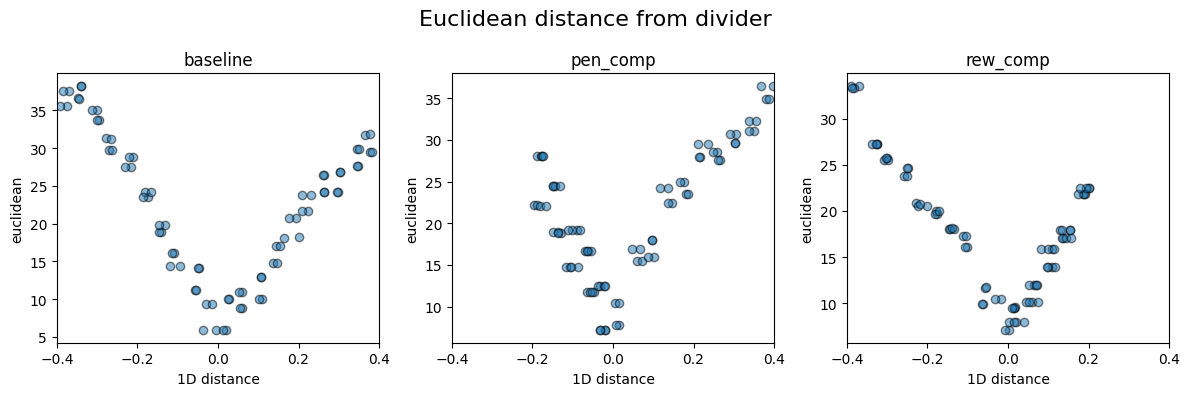

In [226]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs, ax = axs.flatten(), 0
fig.suptitle('Euclidean distance from divider', fontsize=16)
jitter = .01

for cond, cond_df in nn_df.groupby('condition'):

    # plot euc dist (y) vs. 1D dist (x)
    scatter = axs[ax].scatter(cond_df['1D_dist_frm_div'] + np.random.normal(0, jitter, size=len(cond_df)),
                              cond_df['euc_dist_frm_div'] + np.random.normal(0, jitter, size=len(cond_df)),
                              edgecolor='k', alpha=0.5, marker='o')

    axs[ax].set_xlabel('1D distance')
    axs[ax].set_ylabel('euclidean')
    axs[ax].set_title(f'{cond}')
    # axs[ax].set_ylim(0, 15)
    axs[ax].set_xlim(-.4, .4)
    ax += 1

plt.tight_layout()
plt.show()

## cost-weighted classification

In [ ]:
# from sklearn.model_selection import train_test_split

# # architecture params
# # input_dim, hidden_dim, output_dim = n_feats+1, 128, n_feats+1
# input_dim, hidden_dim, recon_dim, class_dim = X.shape[1], 128, y_recon.shape[1], 1
# model = ShapeSideNN(input_dim, hidden_dim, recon_dim, class_dim)

# # loss params
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# recon_wt, class_wt = .5, .5

# # reward matrix: (true_label, predicted_label) → reward
# reward_matrix = {
#     (1, 1): 3,   # true positive
#     (0, 0): 1,   # true negative
#     (1, 0): -1,  # false negative
#     (0, 1): -3   # false positive
# }
# # negation to cast as loss
# cost_matrix = {k: -v for k, v in reward_matrix.items()}

# # split into train and test once
# X_train, X_test, y_recon_train, y_recon_test, y_class_train, y_class_test = train_test_split(
#     X, y_recon, y_class, test_size=.6, random_state=42, shuffle=True
# )

# train_total_losses, train_recon_losses, train_class_losses = [], [], []
# test_total_losses, test_recon_losses, test_class_losses = [], [], []
# epochs = 2000

# # training loop
# for epoch in range(epochs):
#     model.train()

#     # forward pass to predict reconstruction & class
#     pred_recon_train, pred_class_train = model(torch.tensor(X_train, dtype=torch.float32))

#     # 1. reconstruction loss between pred & y
#     train_recon_loss = nn.MSELoss()(pred_recon_train,
#                                     torch.tensor(y_recon_train, dtype=torch.float32))

#     # 2. classification loss 
#     # get binary predicted class from logits
#     sigmoids = (torch.sigmoid(pred_class_train) >= .5).float()

#     # map (true, pred) → cost
#     weights = torch.tensor([
#         cost_matrix[(t.item(), p.item())] for t, p in zip(y_class_train, sigmoids)
#     ], dtype=torch.float32).unsqueeze(1)

#     # compute loss per sample, then apply cost-based weights
#     bce = nn.BCEWithLogitsLoss(reduction='none')(pred_class_train,
#                                                  torch.tensor(y_class_train, dtype=torch.float32))
#     train_class_loss = (weights * bce).mean()

#     # 3. weighted summed training loss
#     train_total_loss = recon_wt * train_recon_loss + class_wt * train_class_loss

#     # backward pass and optimization
#     optimizer.zero_grad()
#     train_total_loss.backward()
#     # to try to take care of exploding gradients (manifested as sudden, high losses)?
#     torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#     optimizer.step()

#     # testing model
#     model.eval()
#     with torch.no_grad():

#         # predict test shape & class using trained model
#         pred_recon_test, pred_class_test = model(torch.tensor(X_test, dtype=torch.float32))        

#         # 1. recon losses between pred & y
#         test_recon_loss = nn.MSELoss()(pred_recon_test, torch.tensor(y_recon_test, dtype=torch.float32))

#         # 2. class loss
#         # get binary predicted class from logits
#         sigmoids = (torch.sigmoid(pred_class_test) >= .5).float()

#         # map (true, pred) → cost
#         weights = torch.tensor([
#             cost_matrix[(t.item(), p.item())] for t, p in zip(y_class_test, sigmoids)
#         ], dtype=torch.float32).unsqueeze(1)

#         # compute loss per sample, then apply cost-based weights
#         bce = nn.BCEWithLogitsLoss(reduction='none')(pred_class_test,
#                                                     torch.tensor(y_class_test, dtype=torch.float32))
#         test_class_loss = (weights * bce).mean()

#         # 3. weighted summed training loss
#         train_total_loss = recon_wt * train_recon_loss + class_wt * train_class_loss

#         # 3. weighted summed testing loss
#         test_total_loss = recon_wt * test_recon_loss + class_wt * test_class_loss

#     # appending train & test losses
#     train_recon_losses.append(train_recon_loss.item())
#     train_class_losses.append(train_class_loss.item())
#     train_total_losses.append(train_total_loss.item())

#     test_recon_losses.append(test_recon_loss.item())
#     test_class_losses.append(test_class_loss.item())
#     test_total_losses.append(test_total_loss.item())


# fig, axs = plt.subplots(1, 3, figsize=(12, 4))
# axs, ax = axs.flatten(), 0
# fig.suptitle('Model Performance', fontsize=16)

# # loss curves
# axs[ax].plot(train_total_losses, label='train')
# axs[ax].plot(test_total_losses, label='test')
# axs[ax].set_xlabel('epochs')
# axs[ax].set_ylabel('loss')
# # axs[0].set_ylim(0, 5)
# axs[ax].set_title('Loss Reduction')
# axs[ax].legend()
# ax += 1

# # sigmoidal probabilities
# sigmoids = torch.sigmoid(pred_class_test).detach().numpy()
# # print(f'Binary classification accuracy: {np.mean((sigmoids > 0.5) == y_class_test.numpy())}')
# print('≈0:', np.sum(sigmoids < .5), ', ≈1:', np.sum(sigmoids > .5))
# print('True classes:', np.bincount(y_class_test.squeeze().astype(int)))
# axs[ax].hist(sigmoids, bins=20)
# axs[ax].set_xlabel('sigmoidal probability')
# axs[ax].set_ylabel('count')
# axs[ax].set_title('Binary outputs')
# ax += 1

# # true predictions
# model_outputs = pred_class_test.numpy()
# # print min and max
# print(f'min: {np.min(model_outputs)}, max: {np.max(model_outputs)}')
# axs[ax].hist(model_outputs, bins=20)
# axs[ax].set_xlabel('model outputs')
# axs[ax].set_ylabel('count')
# axs[ax].set_title('Continuous outputs')

# plt.tight_layout()
# plt.show()



## k-fold CV

In [56]:
# from sklearn.model_selection import KFold

# # architecture params
# input_dim, hidden_dim, output_dim = n_feats, 128, n_feats
# model = ShapeSideNN(input_dim, hidden_dim, output_dim)

# # loss params
# recon_loss_fn, class_loss_fn = nn.MSELoss(), nn.BCELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# recon_wt, class_wt = 0, 5

# # convert to numpy arrays for compatibility with KFold
# X, y_recon, y_class = np.array(X), np.array(y_recon), np.array(y_class)

# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# fold_total_losses, fold_recon_losses, fold_class_losses = [], [], []
# epochs = 2500

# # CV loop
# for fold, (train_id, test_id) in enumerate(kf.split(X)):

#     print(f'fold {fold+1}', end=', ')

#     # split into train and test
#     X_train, X_test = X[train_id], X[test_id]
#     y_recon_train, y_recon_test = y_recon[train_id], y_recon[test_id]
#     y_class_train, y_class_test = y_class[train_id], y_class[test_id]

#     # initialize model, loss, and optimizer
#     model = ShapeSideNN(input_dim, hidden_dim, output_dim)
#     optimizer = optim.Adam(model.parameters(), lr=0.001)

#     epoch_total_losses, epoch_recon_losses, epoch_class_losses = [], [], []
#     beta = 3.0
#     # training loop
#     for epoch in range(epochs):
#         model.train()

#         # forward pass to predict reconstruction & class
#         pred_recon_train, pred_class_train = model(torch.tensor(X_train, dtype=torch.float32))
#         pred_class_train = torch.sigmoid(pred_class_train)

#         # calculate training losses between pred & y
#         train_recon_loss = recon_loss_fn(pred_recon_train, torch.tensor(y_recon_train, dtype=torch.float32))
#         train_class_loss = class_loss_fn(pred_class_train, torch.tensor(y_class_train, dtype=torch.float32))
#         # weighted sum
#         train_total_loss = recon_wt * train_recon_loss + class_wt * train_class_loss

#         # backward pass and optimization; training
#         optimizer.zero_grad()
#         train_total_loss.backward()
#         optimizer.step()

#         # testing model
#         model.eval()
#         test_total_losses, test_recon_losses, test_class_losses = [], [], []
#         with torch.no_grad():

#             # predict left-out (test) shape & class based using trained model on left-out embeddings
#             pred_recon_test, pred_class_test = model(torch.tensor(X_test, dtype=torch.float32))
#             pred_class_test = torch.sigmoid(pred_class_test)

#             # calculate testing losses between pred & y
#             test_recon_loss = recon_loss_fn(pred_recon_test, torch.tensor(y_recon_test, dtype=torch.float32))
#             test_class_loss = class_loss_fn(pred_class_test, torch.tensor(y_class_test, dtype=torch.float32))
#             test_total_loss = recon_wt * test_recon_loss + class_wt * test_class_loss

#         # appending epoch losses
#         epoch_recon_losses.append(test_recon_loss.item())
#         epoch_class_losses.append(test_class_loss.item())
#         epoch_total_losses.append(test_total_loss.item())

#     # appending fold losses
#     fold_recon_losses.append(epoch_recon_losses)
#     fold_class_losses.append(epoch_class_losses)
#     fold_total_losses.append(epoch_total_losses)

# # plot losses
# plt.figure(figsize=(8, 5))
# for i in range(5):
#     plt.plot(fold_total_losses[i], label=f'fold {i+1} class loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('5-fold CV')
# plt.legend()
# plt.show()
